In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds

# Load dataset

In [16]:
ds = tfds.load('diamonds', split='train')
df = tfds.as_dataframe(ds)

In [17]:
df = df[["features/carat", "price"]]

In [18]:
# sns.pairplot(df[["features/carat", "price"]], diag_kind='kde')

In [19]:
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)

In [20]:
carat = np.array(train_df['features/carat'])
price = np.array(train_df['price'])
carat_test = np.array(test_df['features/carat'])
price_test = np.array(test_df['price'])

In [21]:
NUM_TRAIN_SAMPLES = carat.shape[0]

In [22]:
def plot_scatter(x_data, y_data, x_hat=None, y_hats=None, plot_std=False):
    # Plot the data as scatter points
    plt.scatter(x_data, y_data, color="k", label="Data")
    # Plot predicted x and y values, if provided
    if x_hat is not None and y_hats is not None:
        if not isinstance(y_hats, list):
            y_hats = [y_hats]
        for ind, y_hat in enumerate(y_hats):
            plt.plot(
                x_hat,
                y_hat.mean(),
                color="#e41a1c",
                label="Prediction" if ind == 0 else None,
            )
    # Plot standard deviation, if requested
    if plot_std:
        for ind, y_hat in enumerate(y_hats):
            plt.plot(
                x_hat,
                y_hat.mean() + 2 * y_hat.stddev(),
                color="#e41a1c",
                linestyle="dashed",
                label="Prediction + stddev" if ind == 0 else None,
            )
            plt.plot(
                x_hat,
                y_hat.mean() - 2 * y_hat.stddev(),
                color="#e41a1c",
                linestyle="dashed",
                label="Prediction - stddev" if ind == 0 else None,
            )
    # Plot x and y labels
    plt.xlabel("carat")
    plt.ylabel("price")
    plt.legend()

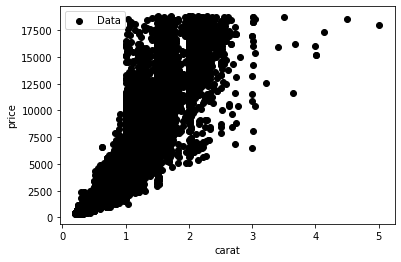

In [23]:
plot_scatter(carat, price)

# *Case* 1: No *uncertainty*


In [24]:
# create layer that normalises the inputs
normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
normalizer.adapt(carat)

In [25]:
def negloglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [26]:
# build model
model = tf.keras.Sequential(
    [
        normalizer,
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1),
        tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(loc=t, scale=1)
        ),
    ]
)

In [27]:
# Compile
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

# Fit
model.fit(carat, price, epochs=100, verbose=0)

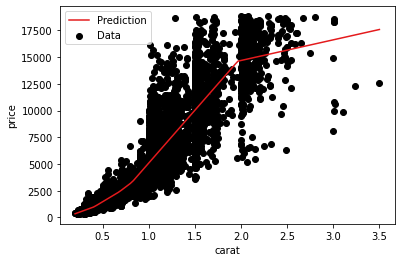

In [28]:
carat_hat = tf.linspace(carat_test.min(), carat_test.max(), 100)
price_hat = model(carat_hat)
plot_scatter(carat_test, price_test, carat_hat, price_hat)

# *Case* 2: Aleatoric uncertainty


In [29]:
# Build model.
model_aleatoric = tf.keras.Sequential(
    [
        normalizer,
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(2),
        tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(
                loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:])
            )
        ),
    ]
)

# Compile
model_aleatoric.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik
)
# Fit
model_aleatoric.fit(carat, price, epochs=100, verbose=0)

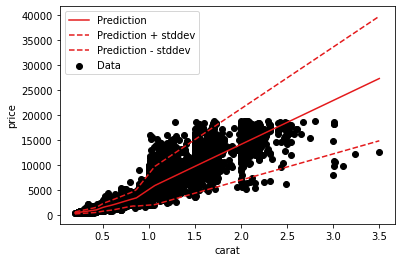

In [30]:
carat_hat = tf.linspace(carat_test.min(), carat_test.max(), 100)
price_hat = model_aleatoric(carat_hat)
plot_scatter(
    carat_test, price_test, carat_hat, price_hat, plot_std=True,
)

# *Case* 3: Epistemic uncertainty

In [31]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(n, dtype=dtype),
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.Independent(
                    tfp.distributions.Normal(loc=t, scale=1),
                    reinterpreted_batch_ndims=1,
                )
            ),
        ]
    )

In [32]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.0))
    return tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(2 * n, dtype=dtype),
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.Independent(
                    tfp.distributions.Normal(
                        loc=t[..., :n],
                        scale=1e-5 + tf.nn.softplus(c + t[..., n:]),
                    ),
                    reinterpreted_batch_ndims=1,
                )
            ),
        ]
    )

In [33]:
# Build model.
def build_epistemic_model():
  model = tf.keras.Sequential(
      [
          normalizer,
          tfp.layers.DenseVariational(
              32,
              make_prior_fn=prior,
              make_posterior_fn=posterior,
              kl_weight=1 / NUM_TRAIN_SAMPLES,
              activation="relu",
          ),
          tfp.layers.DenseVariational(
              1,
              make_prior_fn=prior,
              make_posterior_fn=posterior,
              kl_weight=1 / NUM_TRAIN_SAMPLES,
          ),
          tfp.layers.DistributionLambda(
              lambda t: tfp.distributions.Normal(loc=t, scale=1)
          ),
      ]
  )
  return model

In [34]:
carat_subset = carat[:500]
price_subset = price[:500]

In [35]:
# Build
model_epistemic = build_epistemic_model()
# Compile
model_epistemic.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik
)
# Fit
model_epistemic.fit(carat_subset, price_subset, epochs=100, verbose=0)

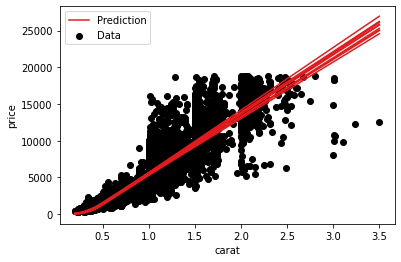

In [36]:
carat_hat = tf.linspace(carat_test.min(), carat_test.max(), 100)
price_hats = [model_epistemic(carat_hat) for _ in range(10)]
plot_scatter(
    carat_test, price_test, carat_hat, price_hats,
)

In [37]:
# Build
model_epistemic_full = build_epistemic_model()
# Compile
model_epistemic_full.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik
)
# Fit
model_epistemic_full.fit(carat, price, epochs=100, verbose=0)

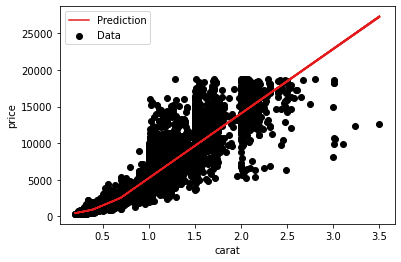

In [38]:
carat_hat = tf.linspace(carat_test.min(), carat_test.max(), 100)
price_hats = [model_epistemic_full(carat_hat) for _ in range(10)]
plot_scatter(
    carat_test, price_test, carat_hat, price_hats,
)

# *Case* 4: epistemic uncertainty + aleatoric uncertainty


In [39]:
# Build model.
model_epistemic_aleatoric = tf.keras.Sequential(
    [
        normalizer,
        tfp.layers.DenseVariational(
            32,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / NUM_TRAIN_SAMPLES,
            activation="relu",
        ),
        tfp.layers.DenseVariational(
            1 + 1,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / NUM_TRAIN_SAMPLES,
        ),
        tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(
                loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:])
            )
        ),
    ]
)

In [40]:
# Compile
model_epistemic_aleatoric.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik
)
# Fit
model_epistemic_aleatoric.fit(carat, price, epochs=100, verbose=0)

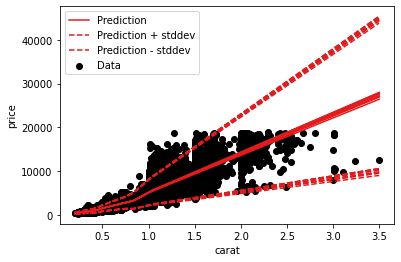

In [41]:
carat_hat = tf.linspace(carat_test.min(), carat_test.max(), 100)
price_hats = [model_epistemic_aleatoric(carat_hat) for _ in range(10)]
plot_scatter(
    carat_test, price_test, carat_hat, price_hats, plot_std=True
)